In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import pydot
import PIL


In [2]:
data_dir_train = pathlib.Path("CNN_assignment/data/Train")
data_dir_test = pathlib.Path("CNN_assignment/data/Test")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training & Validation dataset 

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123, subset="training",  validation_split=0.2
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123, subset="validation",  validation_split=0.2
)

class_names = train_dataset.class_names

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### plot a file from each class

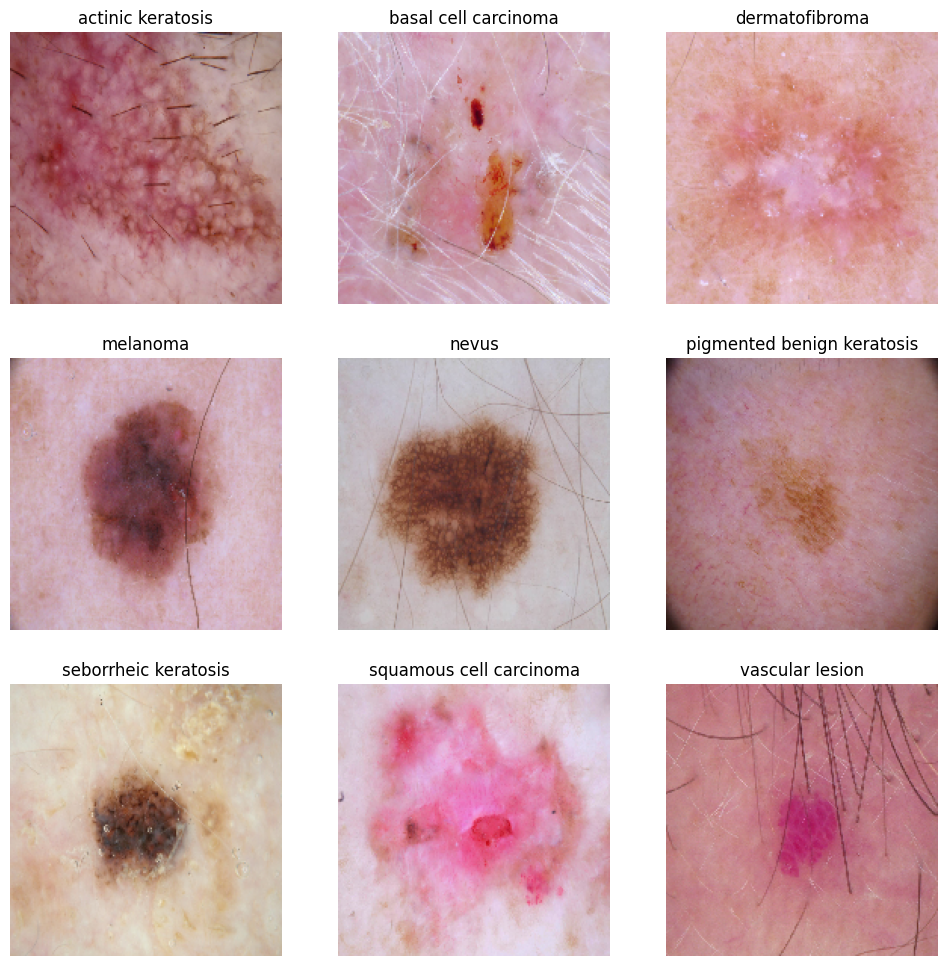

In [6]:
plt.figure(figsize=(12, 12))

for index, cls in enumerate(train_dataset.class_names):
    file_list = os.listdir(os.path.join(data_dir_train, cls))
    plt.subplot(3, 3, index+1)
    plt.imshow(load_img(os.path.join(data_dir_train, cls, file_list[0]), target_size=(180, 180)))
    plt.title(cls)
    plt.axis("off")
plt.show()

In [7]:
def class_img_count(folder):
    # Get a list of all subdirectories
    sub_directories = [path for path in pathlib.Path(folder).iterdir() if path.is_dir()]

    # Get the names and image counts for each subdirectory
    names = [dir.name for dir in sub_directories]
    counts = [len(list(dir.glob('*.jpg'))) for dir in sub_directories]

    # Create a DataFrame and sort it by image count
    df = pd.DataFrame({'class': names, 'image_count': counts})
    df = df.sort_values(by='image_count', ascending=True)

    return df

In [8]:
df = class_img_count(data_dir_train)


In [9]:
df

,class,image_count
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


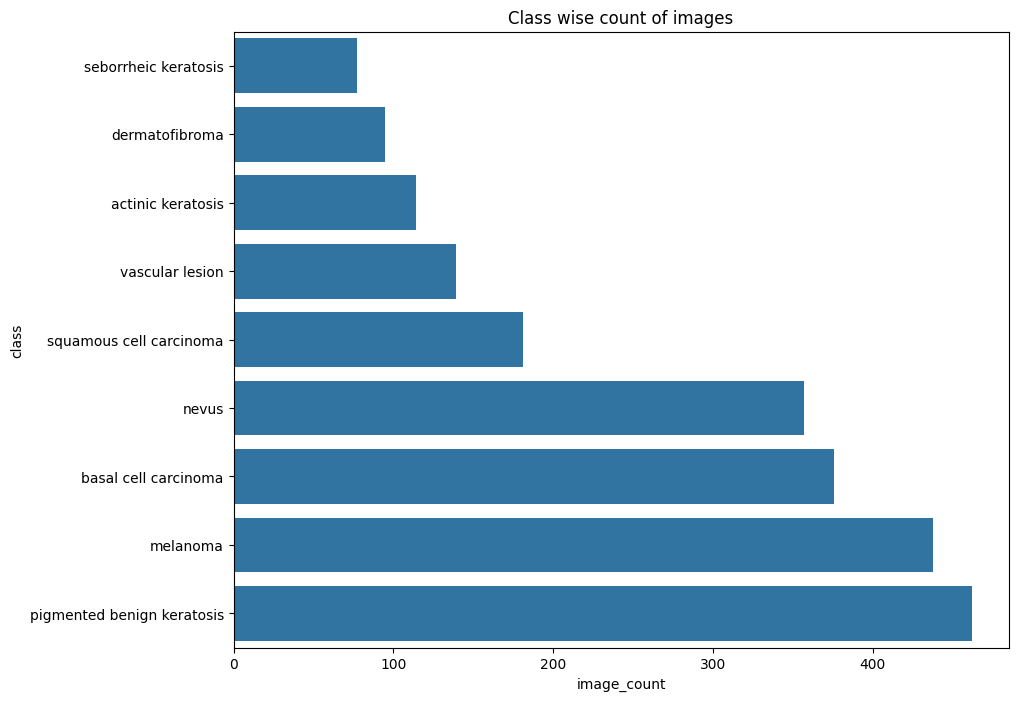

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 8))

sns.barplot(data=df , x='image_count', y='class')

plt.title("Class wise count of images")

plt.show()

In [11]:
# CNN Model Architecture

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer: Scale input pixel values to the [0, 1] range
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 50% Fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer: Convert multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense Layer: Fully connected layer with 128 units and ReLU activation
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
# Softmax scales logits into probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display model summary
model.summary()


C:\Users\vnku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

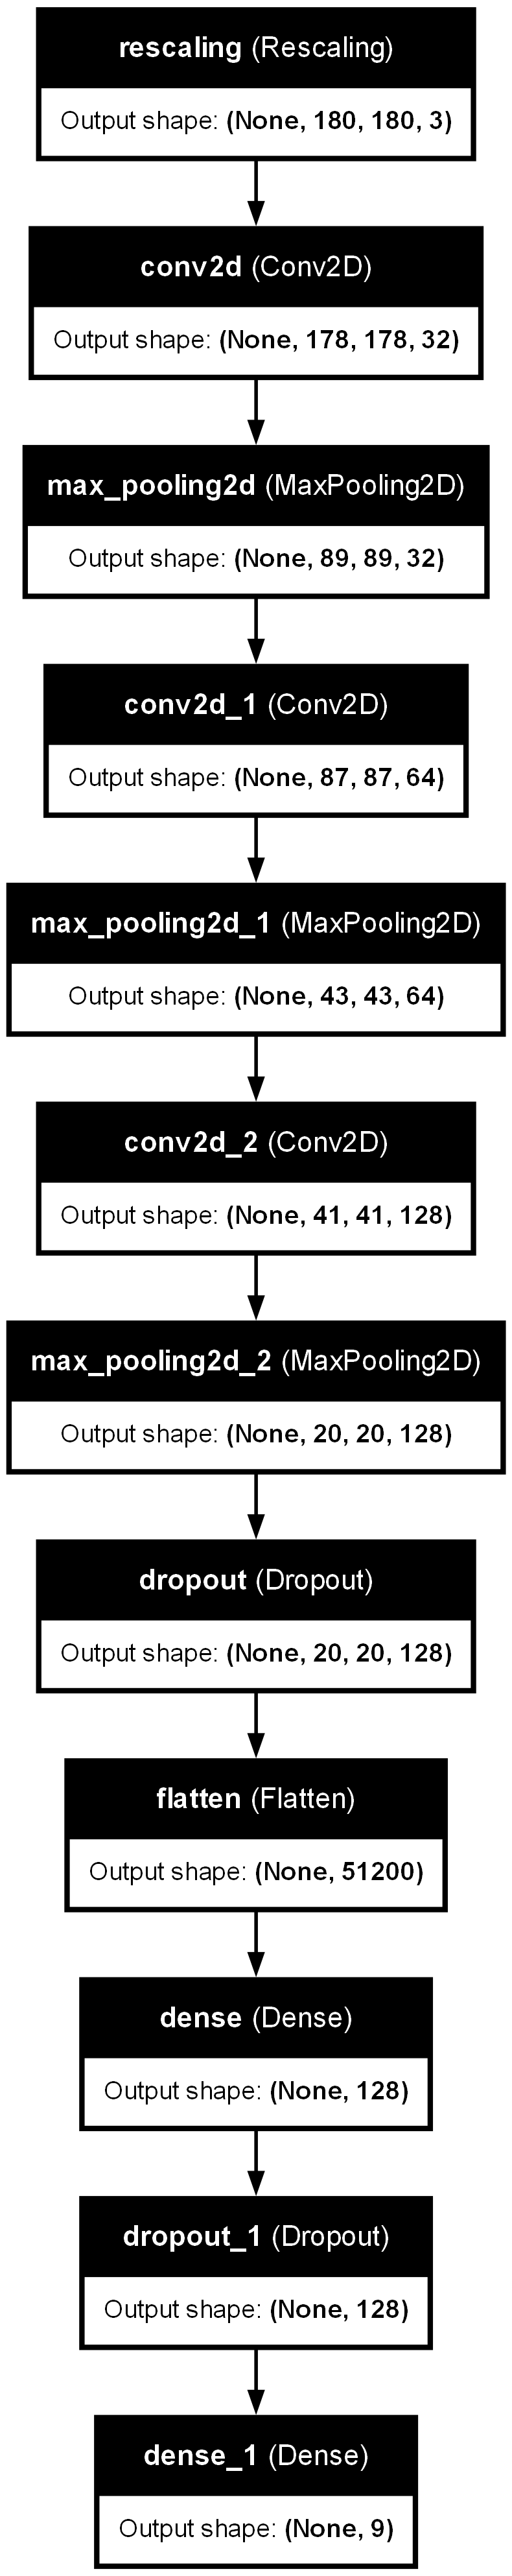

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


### Build the model

In [13]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback is used to save the model or weights at specific intervals
# It saves the best model based on the validation accuracy
# The saved model can be loaded later to continue training from the saved state
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
epochs = 20
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[checkpoint])

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.1787 - loss: 2.1708
Epoch 1: val_accuracy improved from -inf to 0.20582, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 325ms/step - accuracy: 0.1792 - loss: 2.1692 - val_accuracy: 0.2058 - val_loss: 2.0498
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2439 - loss: 2.0077
Epoch 2: val_accuracy improved from 0.20582 to 0.34676, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.2444 - loss: 2.0065 - val_accuracy: 0.3468 - val_loss: 1.7586
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.3350 - loss: 1.8057
Epoch 3: val_accuracy improved from 0.34676 to 0.44072, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 310ms/step - accuracy: 0.3353 - loss: 1.8053 - val_accuracy: 0.4407 - val_loss: 1.6257
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.3950 - loss: 1.6469
Epoch 4: val_accuracy improved from 0.44072 to 0.5167

### Visualize the model results

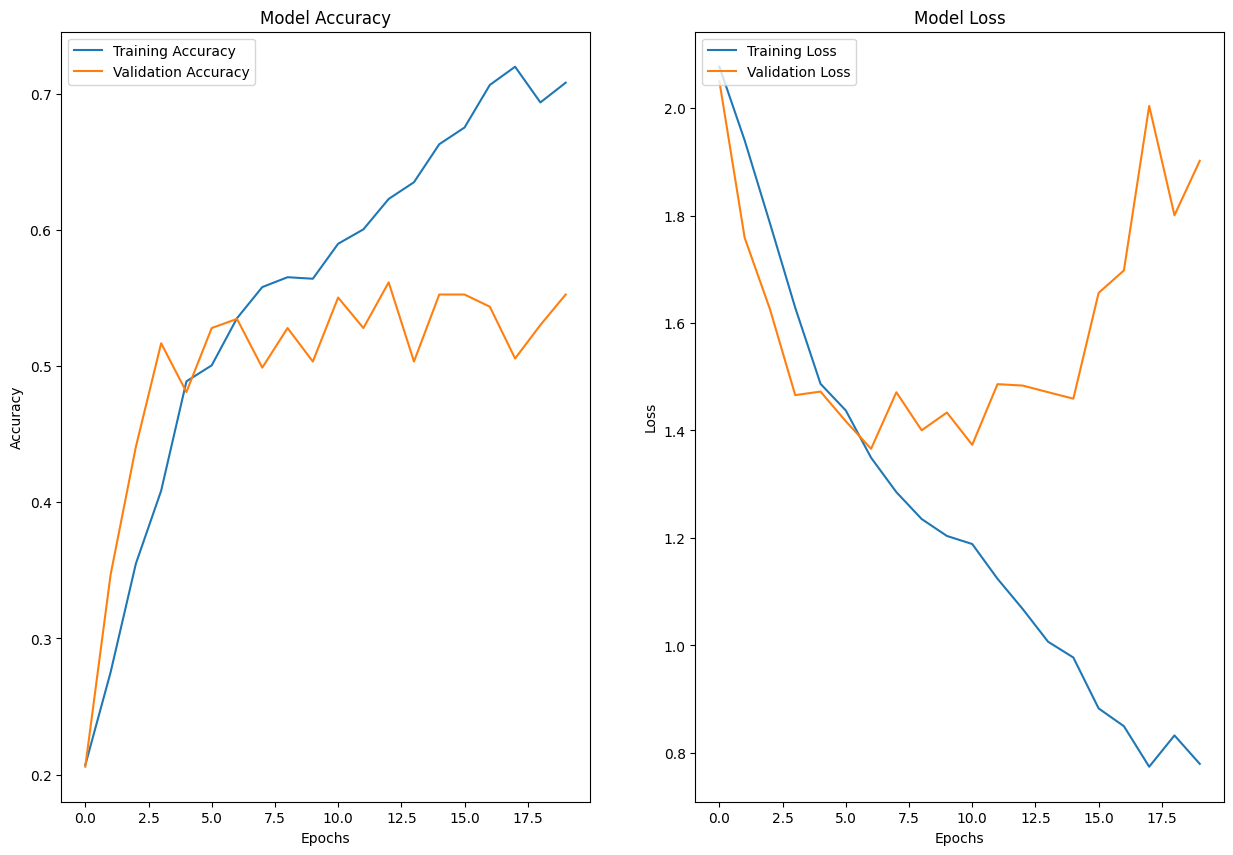

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Augment dataset

In [17]:
!pip install Augmentor

# Import the Augmentor library
import Augmentor

# Loop through each class and perform data augmentation
for c in class_names:
    # Create an Augmentor pipeline for the current class
    p = Augmentor.Pipeline("CNN_assignment/data/Train/" + c)

    # Apply rotation augmentation with specified parameters
    p.rotate(probability=0.70, max_left_rotation=15, max_right_rotation=15)

    # Generate and save 1500 augmented samples for each class
    p.sample(1500)  

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/data/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21F17333B90>: 100%|█| 1500/1500 [00:06<00:00, 239.07 Sampl


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/data/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21F17375DD0>: 100%|█| 1500/1500 [00:06<00:00, 232.73 Sampl


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/data/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21F172D2190>: 100%|█| 1500/1500 [00:06<0


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/data/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2313x1985 at 0x21F17294F90>: 100%|█| 1500/1500 [00:31


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/data/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1007x711 at 0x21F15C42310>: 100%|█| 1500/1500 [00:32<00:00, 46.22 Sampl


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/data/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21F0DB87050>: 100%|█| 1500/1500 [00:07<00:00, 214.12 Sampl


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21F0F556D10>: 100%|█| 1500/1500 [00:15<00:00, 96.78 Sampl


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/data/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21F15FB9C90>: 100%|█| 1500/1500 [00:06<0


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/data/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21F17303750>: 100%|█| 1500/1500 [00:07<00:00, 208.18 Sampl


### Create a training & Validation dataset with augmented data

In [18]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123, subset="training",  validation_split=0.2
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123, subset="validation",  validation_split=0.2
)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [19]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[checkpoint])

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5667 - loss: 1.1914
Epoch 1: val_accuracy improved from 0.56152 to 0.71814, saving model to model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 140s 355ms/step - accuracy: 0.5668 - loss: 1.1912 - val_accuracy: 0.7181 - val_loss: 0.8093
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.6831 - loss: 0.8629
Epoch 2: val_accuracy improved from 0.71814 to 0.74960, saving model to model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 310s 787ms/step - accuracy: 0.6832 - loss: 0.8628 - val_accuracy: 0.7496 - val_loss: 0.7108
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7344 - loss: 0.7119
Epoch 3: val_accuracy improved from 0.74960 to 0.80712, saving model to model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 368s 932ms/step - accuracy: 0.7345 - loss: 0.7118 - val_accuracy: 0.8071 - val_loss: 0.5543
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7854 - loss: 0.5792
Epoch 4: val_accuracy improved fr

### Visualize the model results

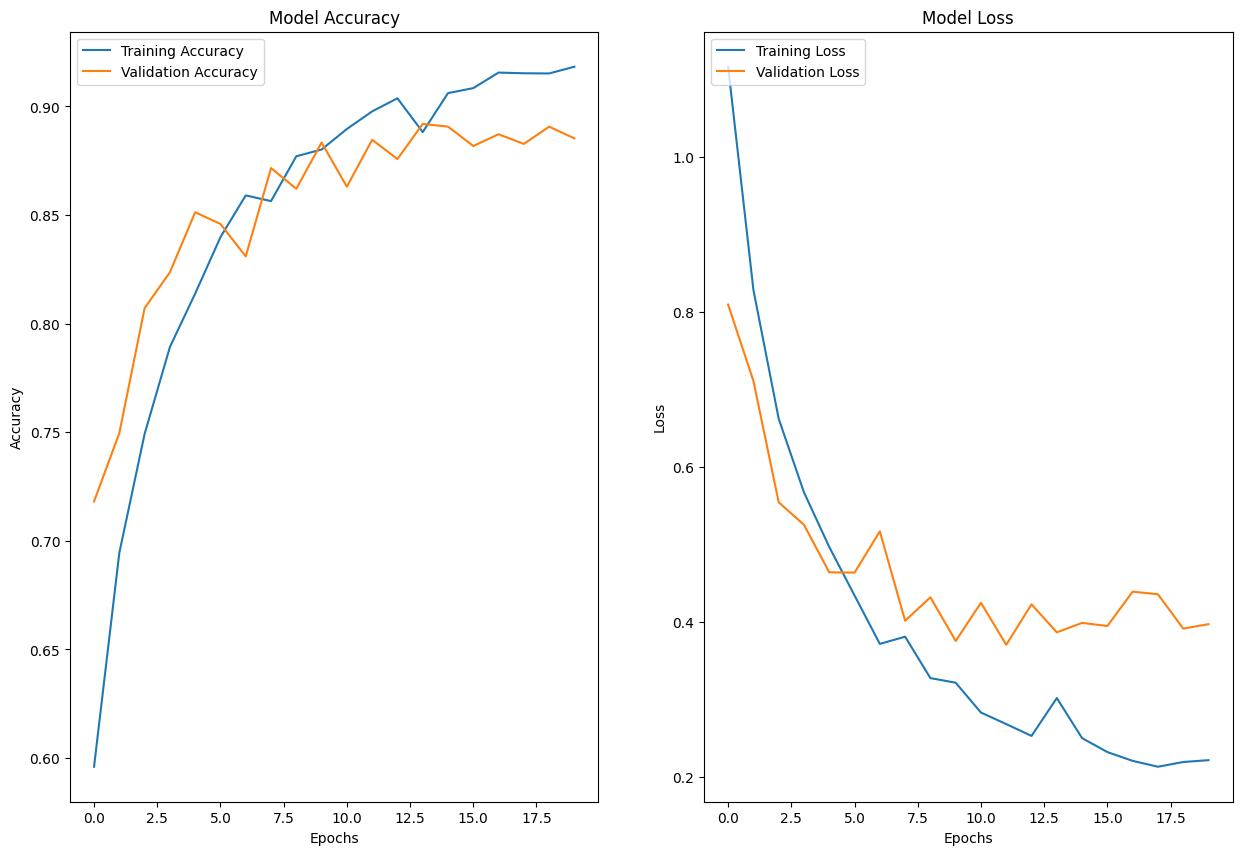

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


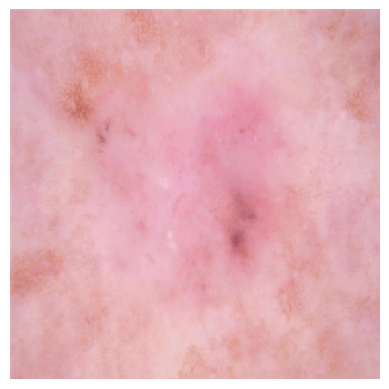

In [24]:
# Construct the path to a test image
test_image_path = os.path.join(data_dir_test, class_names[1], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the second last test image in the list
test_image = load_img(test_images[-2], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.axis("off")

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[1])
print("Predicted Class: " + pred_class)